# <font color='red'>Step 1: Upload Data and Preprocess</font>

In [1]:
#package where fread function is to load csv file
library(data.table)
df <- fread("/Users/heatherharper/Desktop/NMSU/RESEARCH_Ongoing/UK_Speech/hansard-speeches-UKCL-V2_finalfiltered.csv")

In [2]:
library(plyr)
library(dplyr)
library(tm)
library(tidytext)
library(stringr)
library(magrittr)
library(topicmodels)
library(igraph)
library(quanteda)
library(extrafont)
library(ggraph)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: NLP


Attaching package: ‘igraph’


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Package version: 4.1.0
Unicode version: 15.1
ICU version: 75.1

Parallel computing: disabled

See https://quanteda.io for tutorials and examples.


Attaching package: ‘quanteda’


The following object is masked from ‘package:tm’:

    stopwords


The following objects are 

In [3]:
library(ggpubr)
font_import()


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




Importing fonts may take a few minutes, depending on the number of fonts and the speed of the system.
Continue? [y/n]  y


Scanning ttf files in /Library/Fonts/, /System/Library/Fonts, /System/Library/Fonts/Supplemental, ~/Library/Fonts/ ...

Extracting .afm files from .ttf files...

/System/Library/Fonts/Supplemental/Arial Unicode.ttf
 : ArialUnicodeMS already registered in fonts database. Skipping.

/System/Library/Fonts/Apple Braille Outline 6 Dot.ttf
 : AppleBraille-Outline6Dot already registered in fonts database. Skipping.

/System/Library/Fonts/Apple Braille Outline 8 Dot.ttf
 : AppleBraille-Outline8Dot already registered in fonts database. Skipping.

/System/Library/Fonts/Apple Braille Pinpoint 6 Dot.ttf
 : AppleBraille-Pinpoint6Dot already registered in fonts database. Skipping.

/System/Library/Fonts/Apple Braille Pinpoint 8 Dot.ttf
 : AppleBraille-Pinpoint8Dot already registered in fonts database. Skipping.

/System/Library/Fonts/Apple Braille.ttf
 : AppleBraille already registered in fonts database. Skipping.

/System/Library/Fonts/Apple Symbols.ttf
Warning message in system2(enc2native(ttf2pt1

In [4]:
df <- df %>%
  mutate(date.yr.m = substr(date, 1,7))
df <- df %>%
  mutate(month = substr(date.yr.m, 6,7))

#extra stop list; need to get rid of a couple that we don't need--was trying to figure out correct word form
new_stop <- c('also', 'hon', 'minister', 'debate', 'secretaries', 'secretar', 'governs',
              'secretary', 'bill', 'friend', 'committee', 'committees', 'will', 'government', 'governing',
              'must', 'party', 'get', 'go', 'want', 'say', 'one', 'govern', 'people', 'peoples',
              'come', 'can', 'us', 'know', 'mr', 'said', 'refer', 'however', 'make', '£', 'member', 'house', 'gentleman', 'gentlemen')

add_new_stop <- c('think', 'take', 'see', 'look', 'even', 'thing', 'let', 'go') #new word list

In [5]:
#preprocess and stem
df$text <-
  df$speech %>%
  tolower() %>%
  gsub("'s", '',.)%>%
  gsub('[0-9]+', '',.)%>%
  gsub("\\£", " ",.) %>%
  #gsub("\\£", " ",.)%>%
  str_replace_all(., pattern = "[:punct:]|(\\—)|([\\p{Pd}\\xAD\\u2212]+)", replacement = " ") %>%
  gsub('\\b\\w{1,2}\\b',' ',.) %>% #to get rid of words less than 3 letters long
  gsub("—", " ",.) %>%
  removeWords(., c(new_stop, add_new_stop)) %>%
  removeWords(., stopwords("en")) %>%
  stemDocument(., language="english")

In [6]:
#make sure date variable is formatted as a date for subset code below
df$date <- as.Date(df$date, format= "%Y-%m-%d")

# <font color='orange'>Step 2: Select Event Period</font>

In [7]:
#2000
before_90 = "2000-03-20" 
before_1 = "2000-06-17"
event = "2000-06-18"
after_90 = "2000-09-16"
event_name = "2000 Chinese Dover"
event_name_pre = "Pre2000"
event_name_post = "Post2000"
event_short = "2000Event"



df_event0 <- df
df_event0 <- subset(df_event0, date>= before_90 & date <= after_90)

In [8]:
#Recode parties to just 3 
df_event <- df_event0 %>% mutate(party=recode(party, 'Ulster Unionist Party'='Other', 'Liberal Democrat'='Other','Speaker'='Other', 
                                 'Social Democratic & Labour Party'='Other','Labour (Co-op)'='Other', 'Scottish National Party'='Other',
                                 'Plaid Cymru'='Other', 'Labour'='Labour', 'Conservative'='Conservative', 'Independent'='Other'))

# <font color='green'>Step 3a: Run STM and get four different word weights </font>

In [9]:
library(stm)
library(ggplot2)
library(reshape2)
library(tidytext)
library(textstem)
library(textreg)
library(LDAvis)
#library(servr)

stm v1.3.7 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com


Attaching package: ‘reshape2’


The following objects are masked from ‘package:data.table’:

    dcast, melt


Loading required package: koRpus.lang.en

Loading required package: koRpus

Loading required package: sylly

For information on available language packages for 'koRpus', run

  available.koRpus.lang()

and see ?install.koRpus.lang()



Attaching package: ‘koRpus’


The following objects are masked from ‘package:quanteda’:

    tokens, types


The following object is masked from ‘package:tm’:

    readTagged




In [10]:
#create covariate matrix
meta <- df_event %>% 
  select(date, party)

In [11]:
processed <- textProcessor(df_event$text)

Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 
Creating Output... 


In [12]:
out <- prepDocuments(processed$documents, processed$vocab)

Removing 2229 of 5533 terms (2229 of 45768 tokens) due to frequency 
Your corpus now has 496 documents, 3304 terms and 43539 tokens.

In [13]:
#with covariates; not working currently 
Bill_STM <- stm(documents = out$documents, vocab = out$vocab,
              K = 20, prevalence =~ party,
              max.em.its = 75, data = df_event,
              init.type = "Spectral", verbose = FALSE)

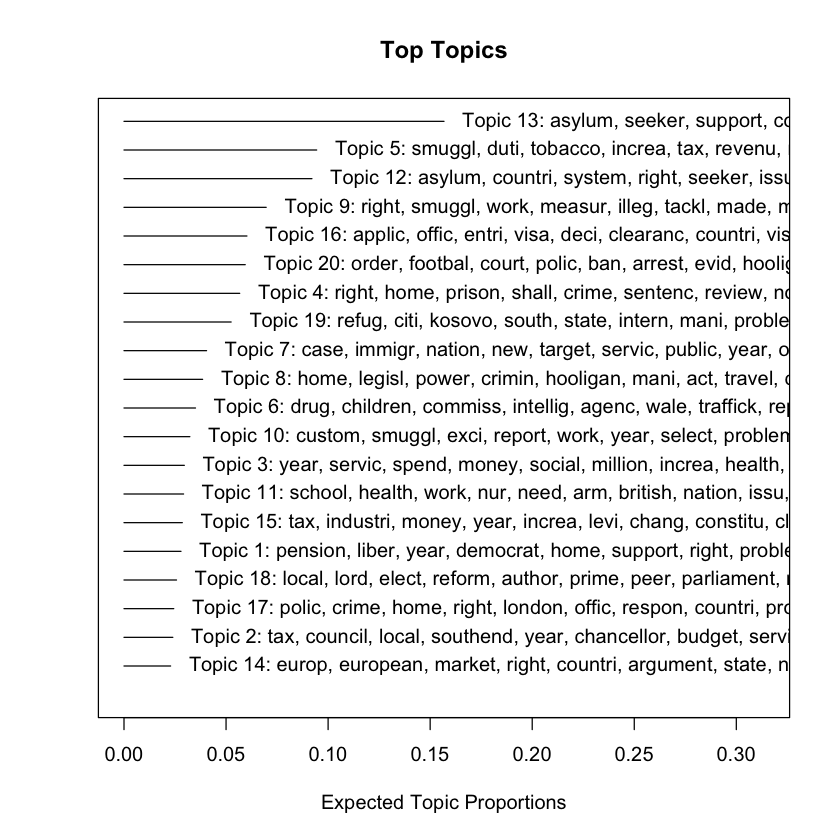

In [14]:
plot(Bill_STM, n=10)

In [15]:
labelTopics(Bill_STM) 

Topic 1 Top Words:
 	 Highest Prob: pension, liber, year, democrat, home, support, right 
 	 FREX: liber, democrat, pension, concessionari, fare, interrupt, england 
 	 Lift: coldfield, writ, bercow, buckingham, concessionari, edinburgh, fowler 
 	 Score: footbal, pension, concessionari, fare, yob, liber, uefa 
Topic 2 Top Words:
 	 Highest Prob: tax, council, local, southend, year, chancellor, budget 
 	 FREX: southend, council, chancellor, tax, budget, brief, charg 
 	 Lift: stealth, uxbridg, fox, fiasco, chariti, tec, strand 
 	 Score: southend, uxbridg, budget, council, tax, chancellor, chariti 
Topic 3 Top Words:
 	 Highest Prob: year, servic, spend, money, social, million, increa 
 	 FREX: spend, social, grant, fund, southend, money, million 
 	 Lift: approxim, cumbria, dna, fur, sand, shut, carer 
 	 Score: southend, cumbria, carer, spend, disabl, grant, nhs 
Topic 4 Top Words:
 	 Highest Prob: right, home, prison, shall, crime, sentenc, review 
 	 FREX: prison, sentenc, curfew,

# <font color='green'>Step 4: Extract Gamma DF, Transform to Binary, divide into Pre and Post Period</font>

In [16]:
#create gamma matrix
dfg <- as.data.frame(Bill_STM$theta)

dfg[] <- t(apply(dfg, 1, function(x) replace(x, x == max(x, na.rm = TRUE), 1)))

In [17]:
#try to get gamma matrix for speeches

dfg_all <- rbind.fill( df_event, dfg)

#then convert rest of values using threshold
x <- 0.2
dfg[dfg>=x]=1
dfg[dfg<x]=0

dfg$author <- df_event$display_as
dfg$date <- df_event$date
dfg <- dfg[, c(21:22, 1:20)]

In [18]:
#Event dfs
dfg_pre <- subset(dfg, date>= before_90 & date <= before_1) %>%
    select(-date)

dfg_post <- subset(dfg, date>= event & date <= after_90) %>%
    select(-date)

#Speeches in each
nrow(dfg_pre)
nrow(dfg_post)

[1] 323

[1] 173

In [19]:
dfg_pre = aggregate(dfg_pre,
                    by = list(dfg_pre$author),
                    FUN = max)

dfg_post = aggregate(dfg_post,
                     by = list(dfg_post$author),
                     FUN = max)

# <font color='blue'> Step 5A: PRE Event Network</font>

## <font color='DodgerBlue'> 5A.1 Drop author names</font>

In [20]:
### pre period- drop author names before running and rename topic names from V1 -> 1
rownames(dfg_pre) <- dfg_pre$Group.1

dfg_pre <- dfg_pre %>%
  select(-Group.1, -author)

colnames(dfg_pre) <- c('1','2','3', '4', '5', '6', '7', '8', '9', '10', 
                                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20') 

## <font color='DeepSkyBlue'> 5A.2 Speaker-Concept Network</font>

In [21]:
bn_full_pre <- graph_from_incidence_matrix(dfg_pre)


l7 <- layout_with_fr(bn_full_pre)
l7 <- norm_coords(l7, ymin=-0.8, ymax=0.7, xmin=-1, xmax=1)

sizes2 <- c(rep(5, 126), rep(12, 20))
shapes <- c("circle","square")
colors <- c("grey", "darkgrey")

Warning message:
“`graph_from_incidence_matrix()` was deprecated in igraph 1.6.0.
ℹ Please use `graph_from_biadjacency_matrix()` instead.”


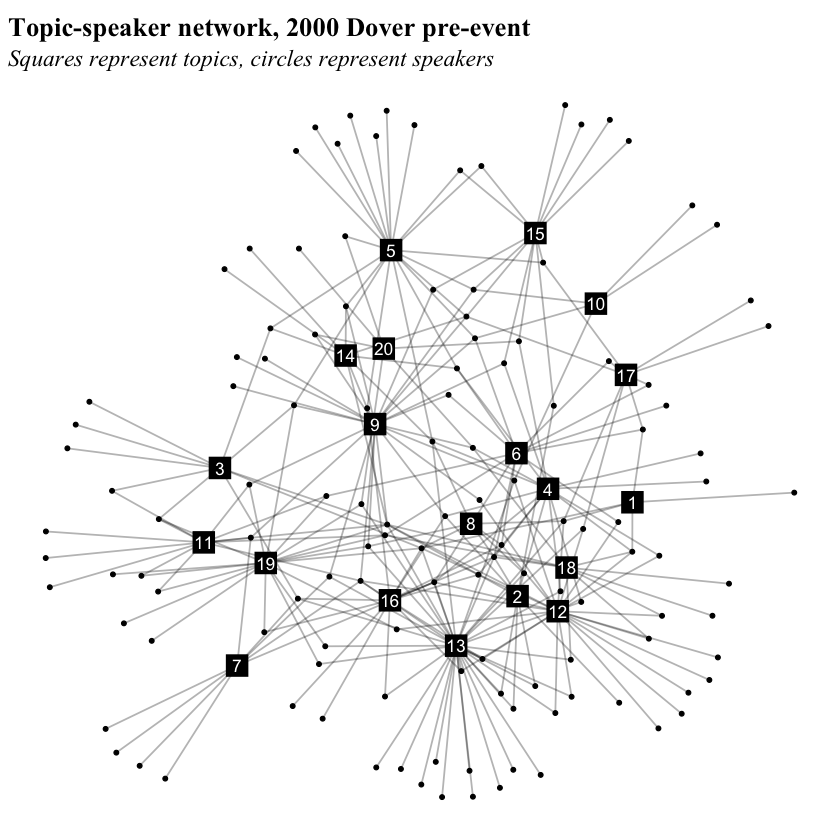

In [22]:
layout = layout_with_fr(bn_full_pre, niter=400)


g_dov_pre <- ggraph(bn_full_pre, layout = 'fr') +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_pre)$type+1], size= sizes2)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    title = "Topic-speaker network, 2000 Dover pre-event",
    subtitle = "Squares represent topics, circles represent speakers"
  ) 

g_dov_pre

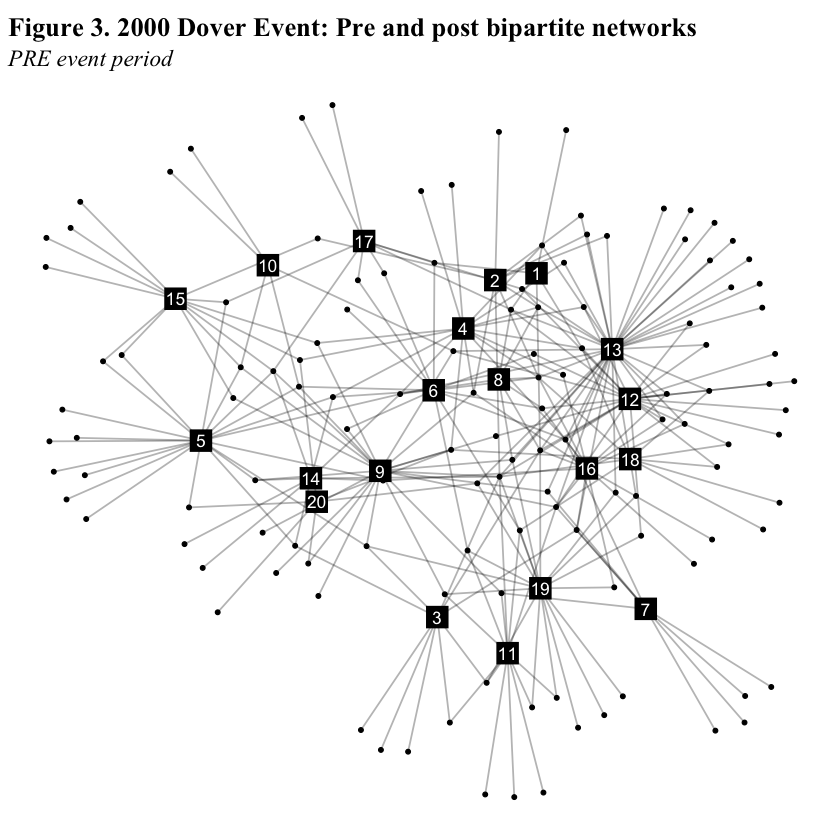

In [29]:
layout = layout_with_fr(bn_full_pre, niter=400)


g_dov_pre2 <- ggraph(bn_full_pre, layout = l7) +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_pre)$type+1], size= sizes2)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    title = "Figure 3. 2000 Dover Event: Pre and post bipartite networks",
    subtitle = "PRE event period"
  ) 

g_dov_pre2

# <font color='PURPLE'>STEP 6: POST Event Network</font>

## <font color='DarkOrchid'> 6A.1 Drop Author Names</font>

In [24]:
### post period drop author names and change topics to V1 -> 1
rownames(dfg_post) <- dfg_post$Group.1

dfg_post <- dfg_post %>%
  select(-Group.1, -author)

colnames(dfg_post) <- c('1','2','3', '4', '5', '6', '7', '8', '9', '10', 
                                               '11', '12', '13', '14', '15', '16', '17', '18', '19', '20') 

In [26]:
dim(dfg_post)

[1] 85 20

## <font color='MediumPurple'> 6A.2 Speaker-Topic Network</font>

In [27]:
bn_full_post <- graph_from_incidence_matrix(dfg_post)


l8 <- layout_with_fr(bn_full_post)
l8 <- norm_coords(l8, ymin=-0.8, ymax=0.7, xmin=-1, xmax=1)

sizes3 <- c(rep(5, 85), rep(12, 20))
shapes <- c("circle","square")
colors <- c("grey", "darkgrey")

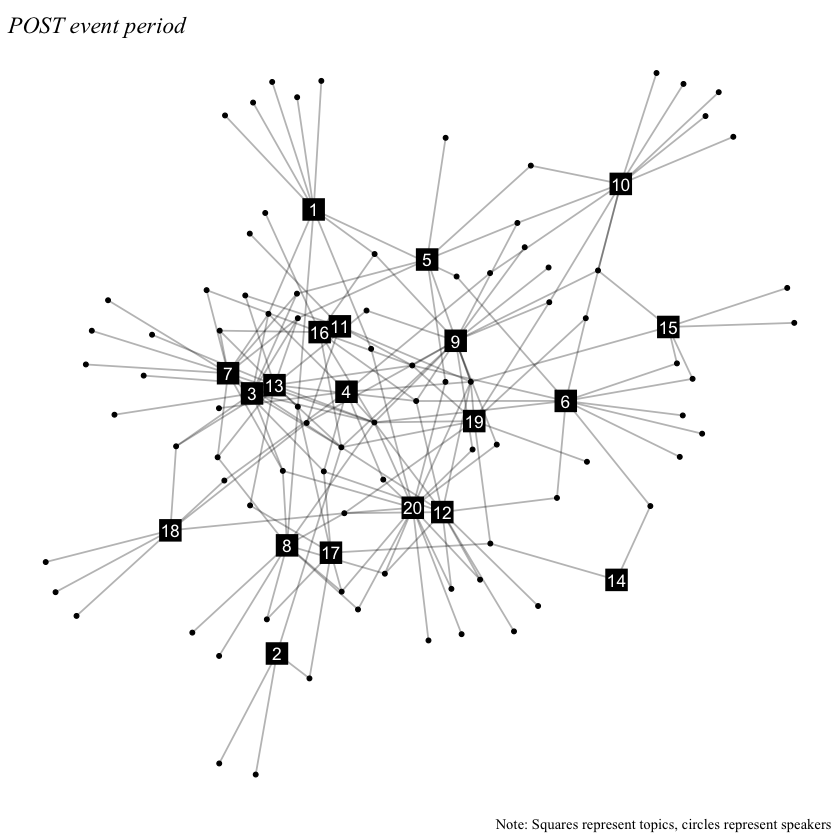

In [28]:
g_dov_post <- ggraph(bn_full_post, layout = l8) +  # You can adjust the layout to 'fr' or any other layout you prefer
  geom_edge_link(alpha = 0.3, color = "black", width = .5) +  # Black edges with reduced alpha
  geom_node_point(aes(color = "black", shape = shapes[V(bn_full_post)$type+1], size= sizes3)) +  # Node points with black/gray color
  geom_node_text(aes(label = ifelse(grepl("\\d", name), name, ""), size = 7, color = "white")) +  # Only label square nodes (shape == 15)# Color nodes (white for Speaker, gray for Topic)
  theme_void() +  
  scale_color_manual(values = c("black", "white")) +  # Color nodes (white for Speaker, gray for Topic)
  scale_shape_manual(values = c(19, 15)) +  # Define shapes for nodes (circle for Speaker, square for Topic)# Minimal theme, removes axis and background grid
  theme(
    text = element_text(family = "Times New Roman"),
    plot.title = element_text(face = "bold", size = 16),  # Title styling
    plot.subtitle = element_text(face = "italic", size = 14),
    legend.position = "none",  # Move legend to the bottom
    legend.key = element_blank(),  # Remove the legend keys (symbols)
    plot.margin = margin(5, 5, 5, 5)  # Add margins around the plot
  ) +
  labs(
    subtitle = "POST event period",
    caption = "Note: Squares represent topics, circles represent speakers"
  ) 

g_dov_post

In [30]:
combined_plot <- ggarrange(g_dov_pre2, g_dov_post,nrow=2, heights = c(2, 2), align="v")

In [31]:
ggsave("/Users/heatherharper/Desktop/Dovercombined_plot.jpeg", combined_plot, height = 10, width = 8)

## <font color='MediumPurple'> 6A.3 Speaker-Speaker Network</font>

In [116]:
### divide into actor-actor and concept-concept networks post-period 

# turn into bipartite network 
bn.pr_f_post <- bipartite.projection(bn_full_post)
bn.pr_f_post 

bn.mem_f_post <- bn.pr_f_post$proj1 
bn.mem_f_post

bn.topics_f_post <- bn.pr_f_post$proj2
bn.topics_f_post

$proj1
IGRAPH c33e011 UNW- 85 748 -- 
+ attr: name (v/c), weight (e/n)
+ edges from c33e011 (vertex names):
 [1] Alan Beith       --Ann Winterton    Alan Beith       --Caroline Spelman
 [3] Alan Beith       --Eddie McGrady    Alan Beith       --Helen Jones     
 [5] Alan Beith       --Jack Straw       Alan Beith       --Jane Kennedy    
 [7] Alan Beith       --John Battle      Alan Beith       --Kevin Barron    
 [9] Alan Beith       --Robin Corbett    Alan Beith       --Ross Cranston   
[11] Alan Beith       --Thomas King      Alexander Randall--Hilary Benn     
[13] Alexander Randall--Jim Marshall     Alexander Randall--John Battle     
[15] Alexander Randall--Tony Blair       Andrew Rowe      --Brian Iddon     
+ ... omitted several edges

$proj2
IGRAPH a36a456 UNW- 20 123 -- 
+ attr: name (v/c), weight (e/n)
+ edges from a36a456 (vertex names):
 [1] V1--V6  V1--V20 V1--V9  V1--V16 V1--V3  V1--V4  V1--V7  V1--V8  V1--V13
[10] V1--V17 V2--V3  V2--V7  V2--V9  V2--V12 V2--V13 V2--V16 V

IGRAPH c33e011 UNW- 85 748 -- 
+ attr: name (v/c), weight (e/n)
+ edges from c33e011 (vertex names):
 [1] Alan Beith       --Ann Winterton    Alan Beith       --Caroline Spelman
 [3] Alan Beith       --Eddie McGrady    Alan Beith       --Helen Jones     
 [5] Alan Beith       --Jack Straw       Alan Beith       --Jane Kennedy    
 [7] Alan Beith       --John Battle      Alan Beith       --Kevin Barron    
 [9] Alan Beith       --Robin Corbett    Alan Beith       --Ross Cranston   
[11] Alan Beith       --Thomas King      Alexander Randall--Hilary Benn     
[13] Alexander Randall--Jim Marshall     Alexander Randall--John Battle     
[15] Alexander Randall--Tony Blair       Andrew Rowe      --Brian Iddon     
+ ... omitted several edges

IGRAPH a36a456 UNW- 20 123 -- 
+ attr: name (v/c), weight (e/n)
+ edges from a36a456 (vertex names):
 [1] V1--V6  V1--V20 V1--V9  V1--V16 V1--V3  V1--V4  V1--V7  V1--V8  V1--V13
[10] V1--V17 V2--V3  V2--V7  V2--V9  V2--V12 V2--V13 V2--V16 V2--V19 V2--V17
[19] V3--V7  V3--V8  V3--V20 V3--V9  V3--V12 V3--V13 V3--V16 V3--V19 V3--V18
[28] V3--V5  V3--V4  V3--V6  V4--V10 V4--V18 V4--V20 V4--V6  V4--V7  V4--V8 
[37] V4--V9  V4--V12 V4--V13 V4--V16 V4--V19 V4--V17 V4--V5  V4--V11 V4--V15
[46] V5--V7  V5--V20 V5--V9  V5--V10 V5--V13 V5--V11 V5--V12 V5--V15 V5--V19
[55] V6--V15 V6--V9  V6--V12 V6--V13 V6--V16 V6--V7  V6--V8  V6--V19 V6--V20
[64] V6--V11 V6--V10 V6--V14 V7--V8  V7--V20 V7--V9  V7--V12 V7--V13 V7--V16
+ ... omitted several edges

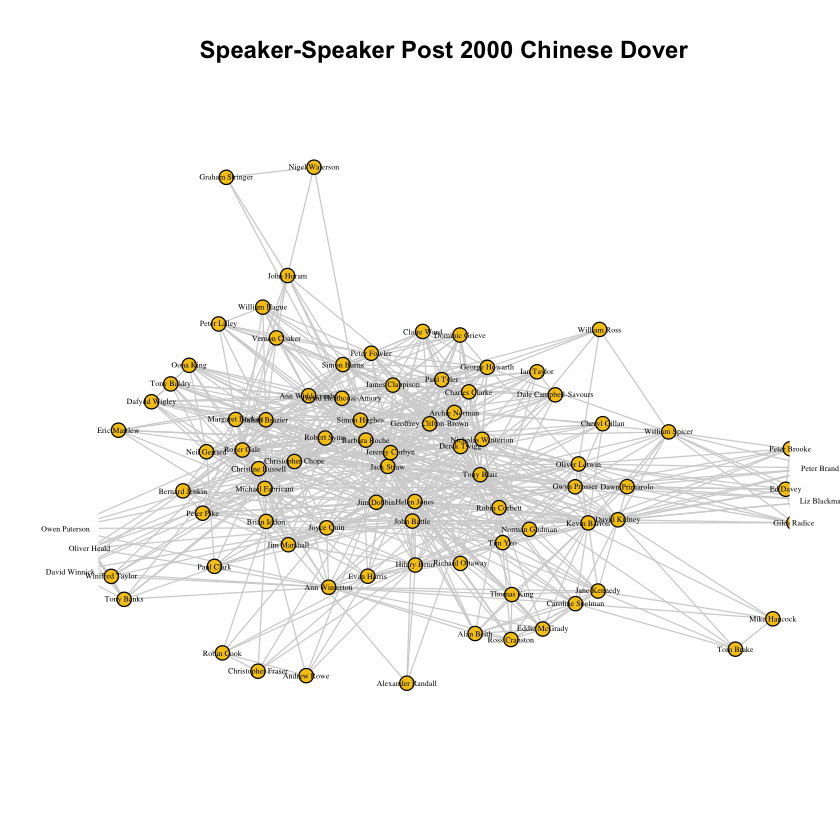

In [117]:
# members - members network post period 
label2= paste("Speaker-Speaker Post", event_name, sep=" ")

l11 <- layout_with_fr(bn.mem_f_post)
l11 <- norm_coords(l11, ymin=-0.8, ymax=0.7, xmin=-1.1, xmax=1.1)

set.seed(1)
plot(bn.mem_f_post,vertex.color="#F5C710", main = label2,
     vertex.shape="circle",main="Speakers", vertex.label.color = "black",edge.color = "light grey",
     vertex.size=5, vertex.label.cex=.4, layout= l11*1.2, rescale = FALSE)

## <font color='MediumPurple'> 6A.4 Topic-Topic Network</font>

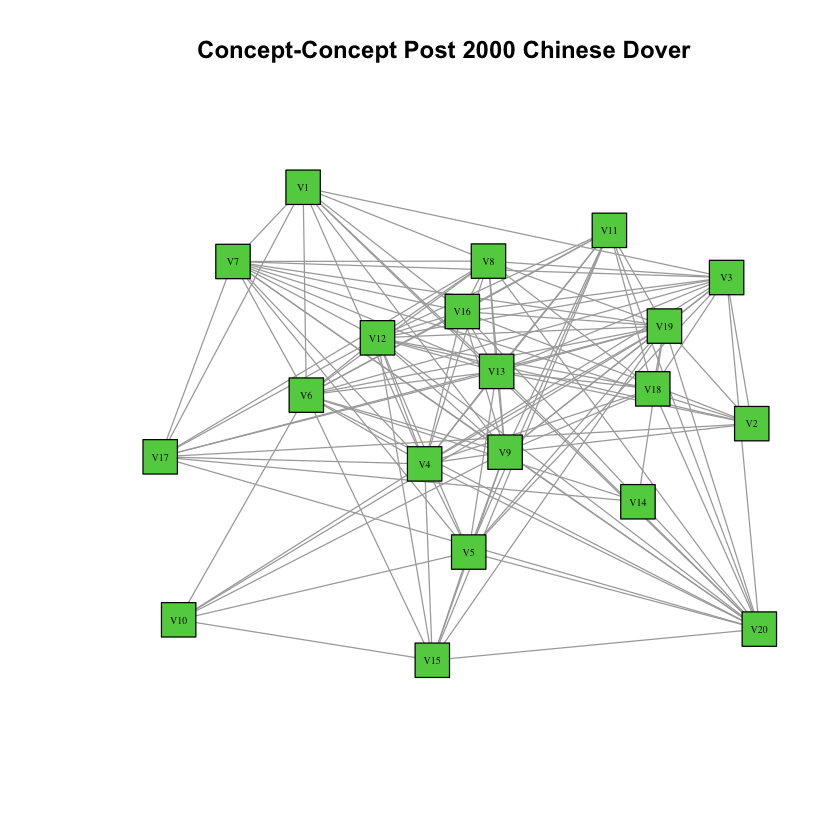

In [118]:
# topic - topic network post period 
label3 = paste("Concept-Concept Post", event_name, sep=" ")

l12 <- layout_with_fr(bn.topics_f_post)
l12 <- norm_coords(l12, ymin=-0.8, ymax=0.7, xmin=-0.9, xmax=1)

set.seed(1)
plot(bn.topics_f_post,vertex.color="#61D04F", main = label3,
     vertex.shape="square",main="Concepts", vertex.label.color = "black",
     vertex.size=12, vertex.label.cex=.5, layout= l9*1.1
     , rescale = FALSE)

## <font color='MediumPurple'> 6A.5 Betweenness Centrality Network</font>

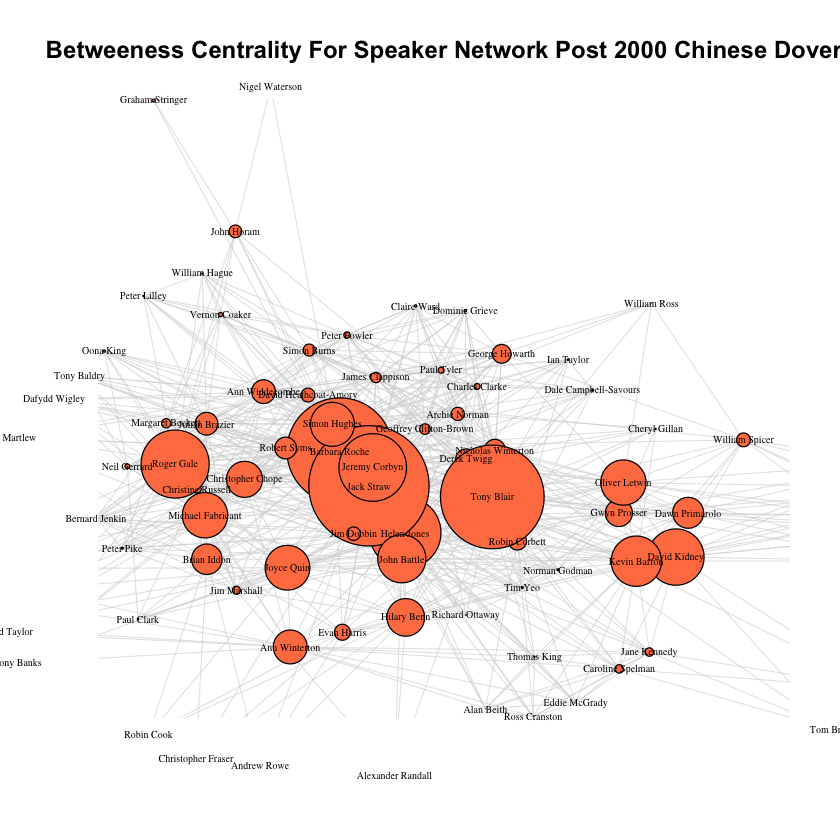

In [119]:
# attach to vertexes 
label4 = paste("Betweeness Centrality For Speaker Network Post", event_name, sep=" ")

V(bn.mem_f_post)$between <- betweenness(bn.mem_f_post, normalized = T)

set.seed(1)
plot(bn.mem_f_post, main = label4,
     vertex.color = "coral",
     vertex.size = V(bn.mem_f_post)$between*500,
     vertex.label.cex = 0.5,
     vertex.label.font = 1.0,
     vertex.label.color = "black", edge.color = "light grey",
     edge.width = 0.5, layout= l11*1.6, rescale = FALSE) 

## <font color='MediumPurple'> 6A.6 Plotting Edge Weights with >1 connections POST-event period</font>

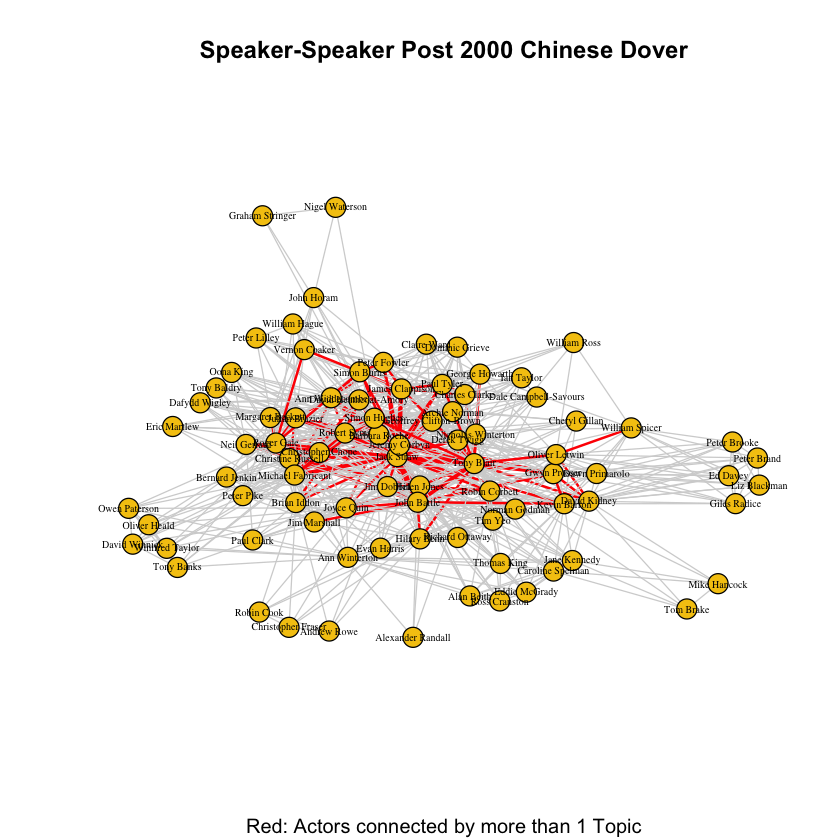

In [120]:
### first let's plot the actor-actor network with weights and highlight those speakers that are connected with others by more than 1 topic 
### plot with edge weights 
label5 = paste("Speaker-Speaker Post", event_name, sep=" ")

# in red: plot connections between actors who share more than 1 topic/concept 
set.seed(1)
plot(bn.mem_f_post,vertex.color="#F5C710", main = label5, 
     sub = "Red: Actors connected by more than 1 Topic",
     vertex.shape="circle",main="Speakers", vertex.label.color = "black",
     vertex.size=7, vertex.label.cex=.5, layout= l11*1, rescale = FALSE, edge.width = E(bn.mem_f_post)$weight, edge.color= ifelse(E(bn.mem_f_post)$weight > 1, "red", "light grey"))

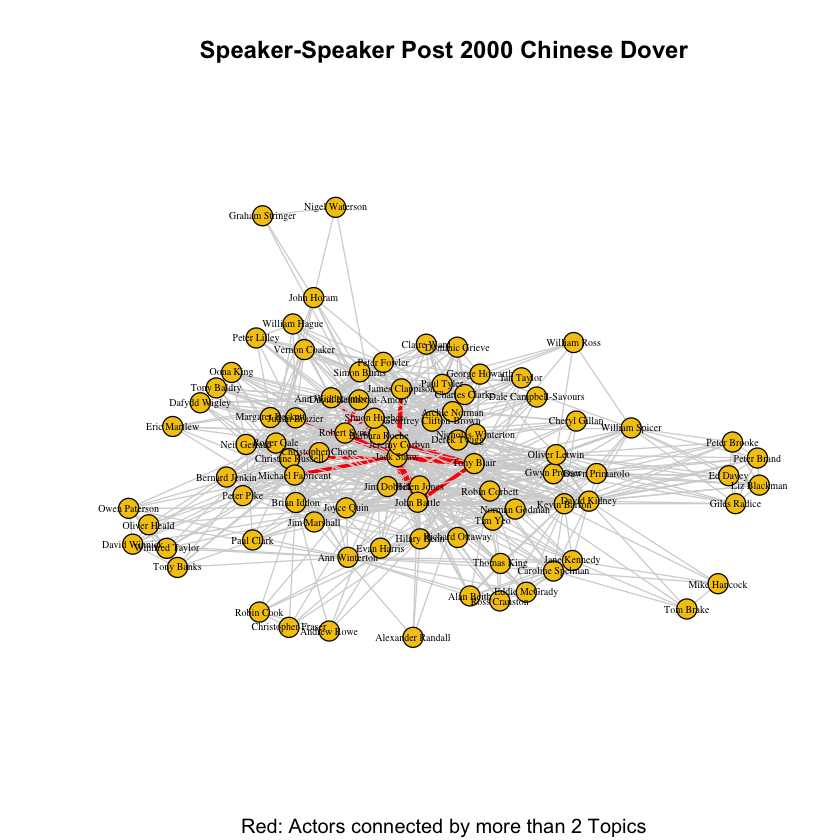

In [121]:
# in red: plot connections between actors who share more than 2 topics/concepts 
label6 = paste("Speaker-Speaker Post", event_name, sep=" ")

set.seed(1)
plot(bn.mem_f_post,vertex.color="#F5C710", main = label6,
     sub = "Red: Actors connected by more than 2 Topics",
     vertex.shape="circle",main="Speakers", vertex.label.color = "black",
     vertex.size=7, vertex.label.cex=.5, layout= l11*1, rescale = FALSE, edge.width = E(bn.mem_f_post)$weight, edge.color= ifelse(E(bn.mem_f_post)$weight > 2, "red", "light grey"))

## <font color='Magenta'> 6B.1 Centrality Measures</font>

### Degree Centrality

In [122]:
head(sort(degree(bn.mem_f_post), decreasing=F)) # fewest connections: 
#Hannah Bardell        Ian Mearns    Matthew Pennycook      Peter Aldous       David Amess    Matthew Offord 
#    19                19                19                   19                20                20 


head(sort(degree(bn.mem_f_post), decreasing=T)) # most connections:
#David Cameron      Theresa May        Keith Vaz  Debbie Abrahams   Chris Grayling Justine Greening 
#281              267              263              259              254              251 

Graham Stringer    Nigel Waterson Alexander Randall      Mike Hancock 
                3                 3                 4                 5 
        Tom Brake       Andrew Rowe 
                5                 6

Jack Straw    Tony Blair Barbara Roche   Helen Jones   John Battle 
           63            47            46            41            38 
Jeremy Corbyn 
           37

In [123]:
# calculate normalized degree centrality and then attach to vertexes (multiply so it can be seen in network)
deg2 <-  degree(bn.mem_f_post, v = V(bn.mem_f_post), mode = c("all"), normalized = T)
deg2
V(bn.mem_f_post)$degree <- (deg2*8) #size the network nodes by their node degree 


Alan Beith      Alexander Randall            Andrew Rowe 
            0.13095238             0.04761905             0.07142857 
        Ann Widdecombe          Ann Winterton          Archie Norman 
            0.38095238             0.23809524             0.17857143 
         Barbara Roche         Bernard Jenkin            Brian Iddon 
            0.54761905             0.15476190             0.27380952 
      Caroline Spelman         Charles Clarke          Cheryl Gillan 
            0.17857143             0.25000000             0.09523810 
     Christine Russell      Christopher Chope     Christopher Fraser 
            0.27380952             0.28571429             0.07142857 
           Claire Ward          Dafydd Wigley  Dale Campbell-Savours 
            0.17857143             0.14285714             0.13095238 
 David Heathcoat-Amory           David Kidney          David Winnick 
            0.22619048             0.30952381             0.10714286 
        Dawn Primarolo            Derek Twigg         Dominic Grieve 
            0.20238095             0.30952381             0.17857143 
              Ed Davey          Eddie McGrady           Eric Martlew 
            0.11904762             0.13095238             0.08333333 
           Evan Harris Geoffrey Clifton-Brown         George Howarth 
            0.15476190             0.23809524             0.23809524 
          Giles Radice        Graham Stringer           Gwyn Prosser 
            0.11904762             0.03571429             0.29761905 
           Helen Jones            Hilary Benn             Ian Taylor 
            0.48809524             0.26190476             0.13095238 
            Jack Straw        James Clappison           Jane Kennedy 
            0.75000000             0.30952381             0.17857143 
         Jeremy Corbyn             Jim Dobbin           Jim Marshall 
            0.44047619             0.27380952             0.19047619 
           John Battle             John Horam             Joyce Quin 
            0.45238095             0.10714286             0.30952381 
        Julian Brazier           Kevin Barron           Liz Blackman 
            0.33333333             0.30952381             0.11904762 
      Margaret Beckett      Michael Fabricant           Mike Hancock 
            0.21428571             0.33333333             0.05952381 
          Neil Gerrard     Nicholas Winterton         Nigel Waterson 
            0.19047619             0.30952381             0.03571429 
         Norman Godman           Oliver Heald          Oliver Letwin 
            0.16666667             0.10714286             0.30952381 
             Oona King          Owen Paterson             Paul Clark 
            0.14285714             0.10714286             0.08333333 
            Paul Tyler            Peter Brand           Peter Brooke 
            0.25000000             0.11904762             0.11904762 
          Peter Fowler           Peter Lilley             Peter Pike 
            0.23809524             0.11904762             0.15476190 
       Richard Ottaway            Robert Syms             Robin Cook 
            0.08333333             0.32142857             0.07142857 
         Robin Corbett             Roger Gale          Ross Cranston 
            0.23809524             0.39285714             0.13095238 
           Simon Burns           Simon Hughes            Thomas King 
            0.28571429             0.36904762             0.14285714 
               Tim Yeo              Tom Brake            Tony Baldry 
            0.16666667             0.05952381             0.14285714 
            Tony Banks             Tony Blair          Vernon Coaker 
            0.10714286             0.55952381             0.16666667 
         William Hague           William Ross         William Spicer 
            0.11904762             0.07142857             0.17857143 
       Winifred Taylor 
            0.10714286

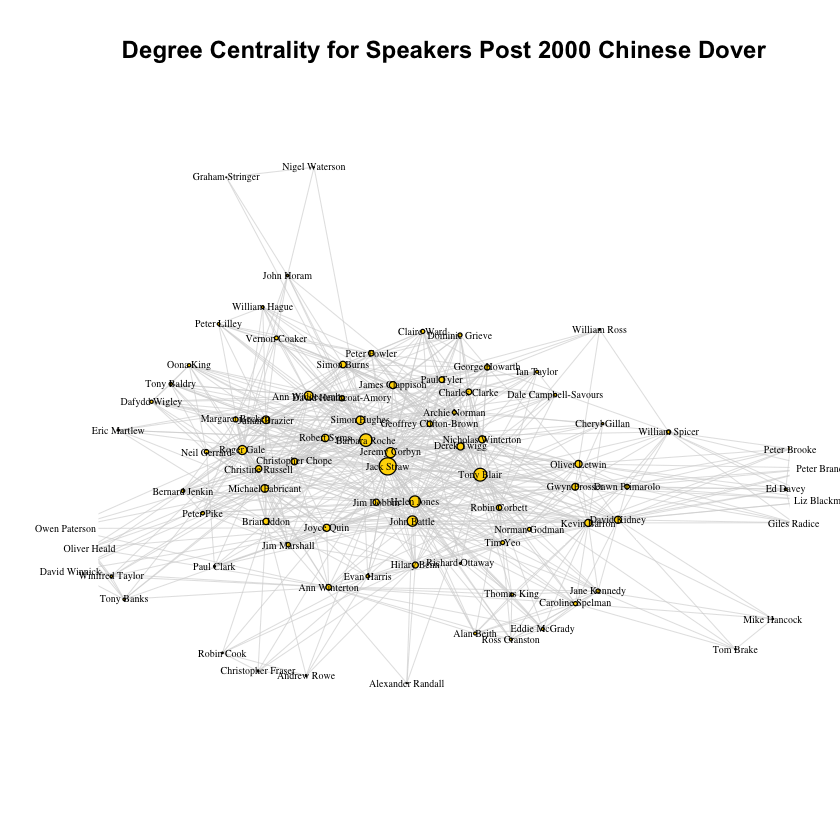

In [124]:
label7 = paste("Degree Centrality for Speakers Post", event_name, sep=" ")

plot(bn.mem_f_post, edge.arrow.size = .5,  main = label7,
     vertex.size = V(bn.mem_f_post)$degree,
     vertex.color = "gold",
     vertex.label.cex = 0.5,
     vertex.label.font = 1.0,
     vertex.label.color = "black",
     edge.width = 0.5, edge.color = "light grey",
     layout= l11*1.2, rescale = FALSE)

In [125]:
### BETWEEN centrality 

tail(sort(betweenness(bn.mem_f_post,normalized = T))) # highest 
#Suella Braverman     Sylvia Hermon    Caroline Lucas       Mary Creagh Stuart C McDonald     Stephen Twigg 
#0.005360945       0.005411882       0.005423371       0.005548630       0.005729948       0.006153389 

head(sort(betweenness(bn.mem_f_post, normalized = T))) # lowest 
#David Amess    Matthew Offord   Matthew Pennycook      Peter Aldous    Hannah Bardell        Ian Mearns 
#6.545848e-05      6.545848e-05      8.201645e-05      8.201645e-05      1.138180e-04      1.138180e-04 

Jeremy Corbyn    Roger Gale   Helen Jones    Tony Blair Barbara Roche 
   0.04719217    0.04752103    0.04995316    0.07231811    0.07380182 
   Jack Straw 
   0.08392660

Andrew Rowe Christopher Fraser      David Winnick    Graham Stringer 
                 0                  0                  0                  0 
    Nigel Waterson       Oliver Heald 
                 0                  0

## <font color='Magenta'> 6B.2 Community Detection</font>

### POST WALKTRAP 2 Steps

In [126]:
### walktrap 
cluster_post <- cluster_walktrap(bn.mem_f_post, steps=2) # 2 random steps 

V(bn.mem_f_post)$community2 <-  membership(cluster_post)
membership(cluster_post)
#E(bn.mem_f_pre)$weight = 1

g_grouped_2 = bn.mem_f_post

for(i in unique(V(bn.mem_f_post)$community2)){
  groupV = which(V(bn.mem_f_post)$community2 == i)
  g_grouped_2 = add_edges(g_grouped_2, combn(groupV, 2), attr=list(weight = 2))
}

l2 <- layout_nicely(g_grouped_2)

            Alan Beith      Alexander Randall            Andrew Rowe 
                     5                      2                      8 
        Ann Widdecombe          Ann Winterton          Archie Norman 
                     4                      2                      2 
         Barbara Roche         Bernard Jenkin            Brian Iddon 
                     2                      2                      2 
      Caroline Spelman         Charles Clarke          Cheryl Gillan 
                     5                      3                      2 
     Christine Russell      Christopher Chope     Christopher Fraser 
                     4                      2                      8 
           Claire Ward          Dafydd Wigley  Dale Campbell-Savours 
                     3                      4                      2 
 David Heathcoat-Amory           David Kidney          David Winnick 
                     4                      1                      7 
        Dawn Primaro

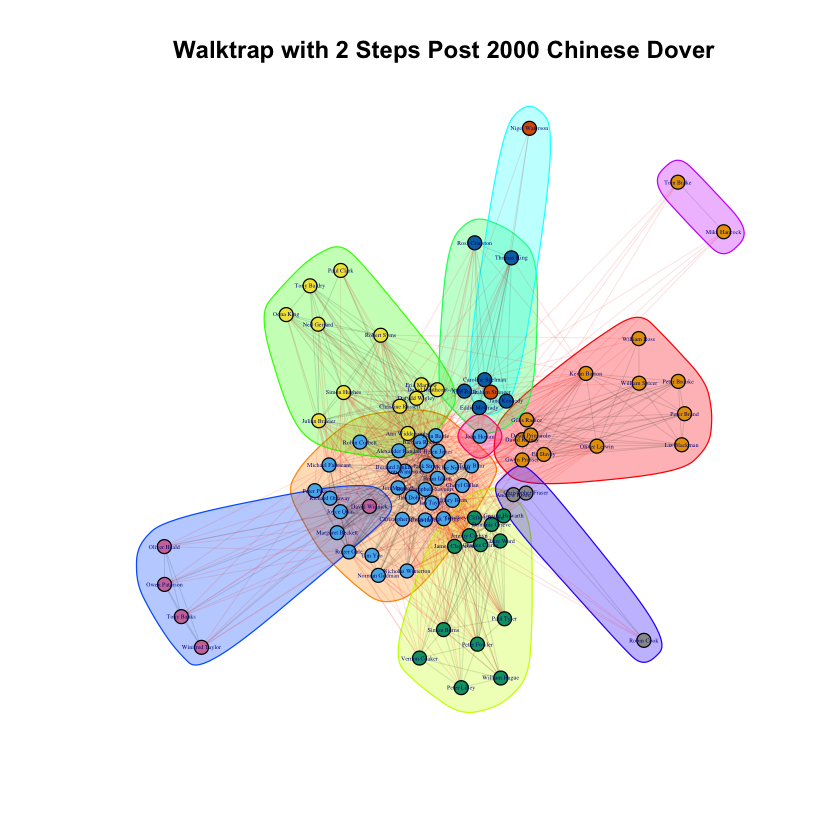

In [127]:
label7 = paste("Walktrap with 2 Steps Post", event_name, sep=" ")

set.seed(1)
plot(cluster_post,bn.mem_f_post, layout = l2*2, vertex.size = 5, edge.width = .1,
     vertex.label.cex=.3, main = label7)

In [128]:
##NEW CODE TO VISUALIZE COMMUNITIES BASED ON NODE CENTRALITY

## Eigenvector centrality 
label21 = paste("Post Walktrap with Degree Centrality", event_name, sep=" ")
label22 = paste("Post Walktrap with Betweenness Centrality", event_name, sep=" ")

eigen_post <-  eigen_centrality(bn.mem_f_post) # use actor-actor network 
#eigen_post$vector

V(bn.mem_f_post)$eigen <- (eigen_post$vector*8) #size the network nodes by their node degree and attach to network graph 

V(bn.mem_f_post)$eigen


[1] 0.6913160 0.3460542 0.2385863 3.3848392 0.9504190 1.1708586 5.9964047
 [8] 1.1547555 2.0170215 0.9038919 2.1598716 0.8829869 2.8248565 1.3773836
[15] 0.2385863 1.1295888 1.0067323 1.0874874 2.0098059 1.6744709 0.2842750
[22] 0.8363102 2.3199824 1.1295888 0.2748138 0.6913160 0.7305222 0.8010174
[29] 1.6690305 1.4696760 0.2748138 0.1807916 2.2884209 4.5195910 1.7440939
[36] 1.0874874 8.0000000 2.8528976 0.9038919 3.7303893 2.3444998 1.4620861
[43] 4.5388870 0.4681438 2.2309424 2.8001055 1.7560956 0.2748138 1.4169777
[50] 2.4134161 0.2365157 1.7727823 2.3199824 0.1807916 1.2518388 0.2842750
[57] 1.8097986 1.0067323 0.2842750 0.8130026 2.1598716 0.2748138 0.2748138
[64] 1.8670794 0.7869406 1.1547555 0.5836462 3.0302512 0.2385863 1.7329070
[71] 2.3398110 0.6913160 2.1047889 2.7584432 0.7223265 1.2518388 0.2365157
[78] 1.0067323 0.2842750 4.9748163 1.0586530 0.7869406 0.3790118 0.6369557
[85] 0.2842750

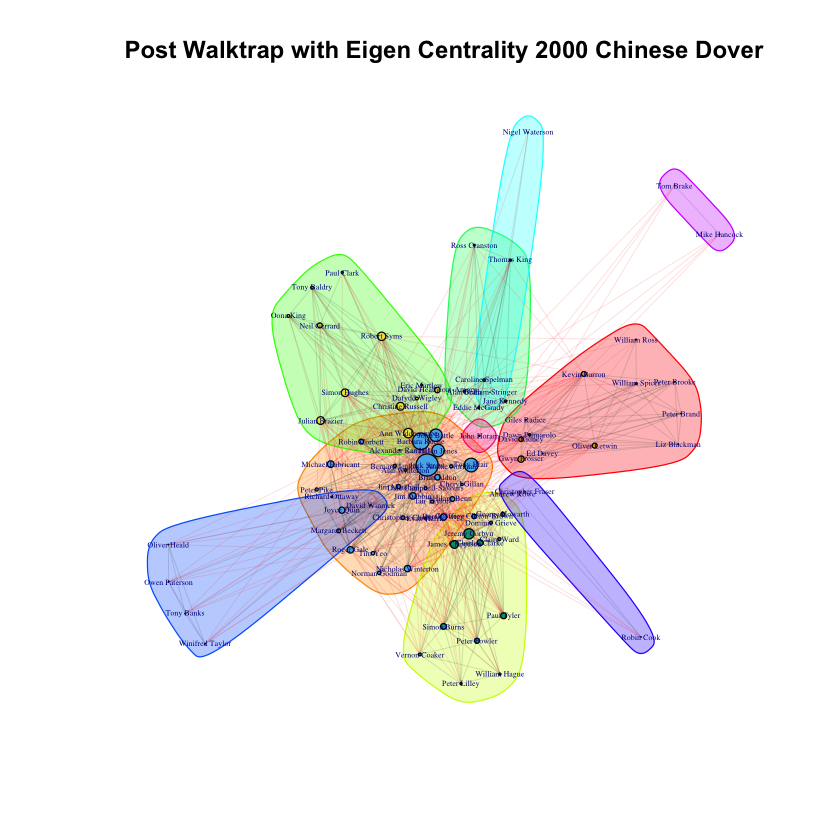

In [141]:
# show communities including nodes sized by eigen centrality  (use same layout as before)
label20 = paste("Post Walktrap with Eigen Centrality", event_name, sep=" ")
set.seed(1)
plot(cluster_post,bn.mem_f_post, layout = l2*2, vertex.size = V(bn.mem_f_post)$eigen, edge.width = .1,
     vertex.label.cex=.4, main = label20)

In [142]:
p1 <- recordPlot()
dev.off()

null device 
          1

### Subset the Post Network

In [130]:
#determine largest group
table(cluster_post$membership) %>% sort()


10  6  9  8  7  5  1  4  3  2 
 1  2  2  3  5  6 12 12 13 29 

In [131]:
membership.data.post <- cbind(cluster_post$names, cluster_post$membership, 0) %>%
  data.frame() #this 0 is just from a previous part of the analysis. It's an indicator for the pre/post-period

In [132]:
#filter out membership less than 5
big_group_post <-membership.data.post %>% 
  group_by(X2) %>% 
  filter(n() >= 5)

group_numbers_post = membership.data.post %>% 
  group_by(X2) %>% 
  filter(n() >= 5) %>% 
  pull(X2) %>% 
  as.numeric(.) %>% 
  unique()


big_names_post <- big_group_post$X1

In [133]:
#adjust to your bn.member_f_pre object
Keep_post = V(bn.mem_f_post)[name %in% big_group_post$X1]

gD2_post  = induced_subgraph(bn.mem_f_post, Keep_post)


In [134]:
c_sub_post = cluster_post
c_sub_post$names <- cluster_post$names[Keep_post]
c_sub_post$membership <- cluster_post$membership[cluster_post$membership %in% group_numbers_post]
c_sub_post$vcount <- length(c_sub_post$names)
c_sub_post$modularity <- modularity(gD2_post, c_sub_post$membership, E(gD2_post)$weight)

g_grouped_post = gD2_post

for(i in unique(V(gD2_post)$community2)){
  groupV = which(V(gD2_post)$community2 == i)
  g_grouped_post = add_edges(g_grouped_post, combn(groupV, 2), attr=list(weight = 2))
}

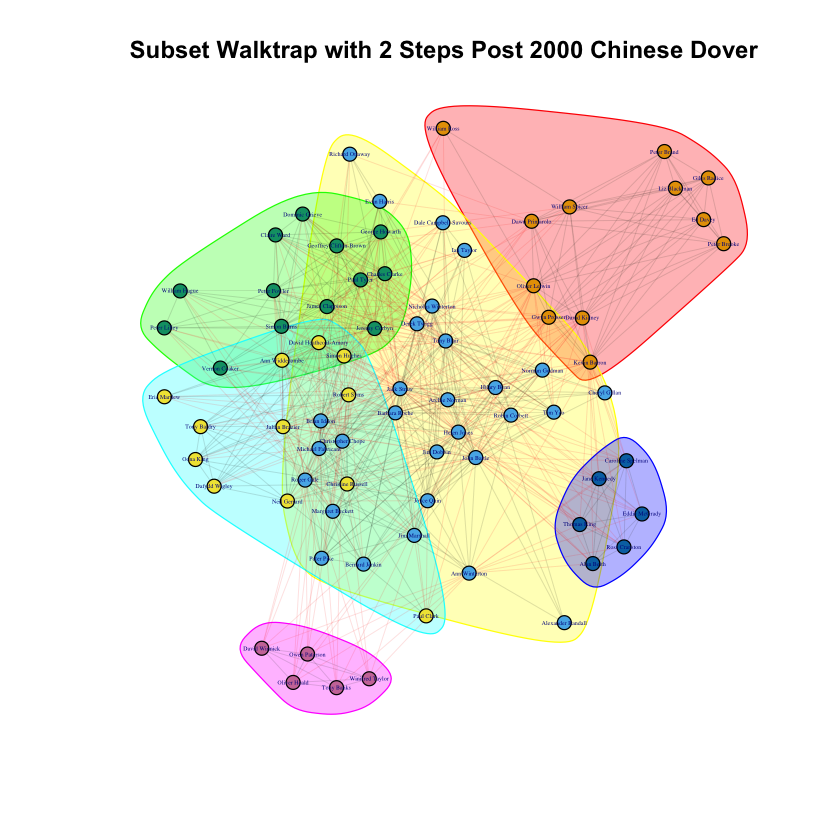

In [143]:
l31 <- layout_nicely(gD2_post)
#l.group <- norm_coords(l.group, ymin=-1, ymax=1, xmin=-0.9, xmax=1)

label31 = paste("Subset Walktrap with 2 Steps Post", event_name, sep=" ")

#regular plot just of the speaker speaker
set.seed(1)
plot(c_sub_post,gD2_post,layout = l31*2, vertex.size = 5, edge.width = .1,
     vertex.label.cex=.3, main = label31)


In [144]:
p2 <- recordPlot()
dev.off()

null device 
          1

In [149]:
install.packages("gridGraphics")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [150]:
library(gridGraphics)

Loading required package: grid



In [146]:
library(ggpubr)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




Warning message in grid.echo.recordedplot(x$x, newpage = FALSE, x$prefix, x$device):
“No graphics to replay”
Warning message in grid.echo.recordedplot(x$x, newpage = FALSE, x$prefix, x$device):
“No graphics to replay”


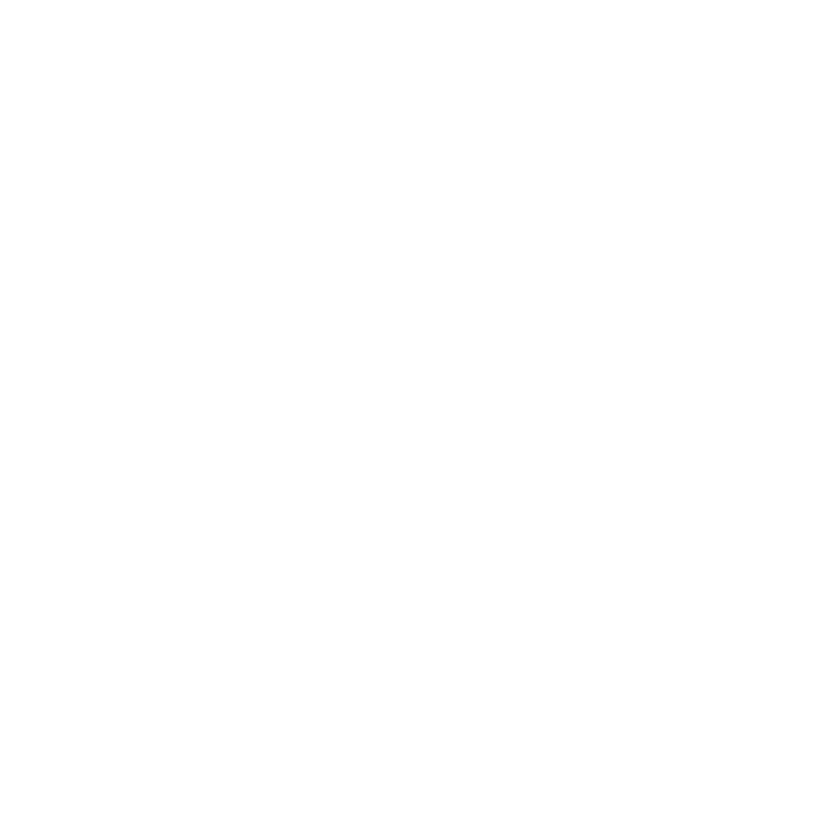

In [151]:
myPlots <- list(p1, p2)

ggpubr::ggarrange(plotlist = myPlots, nrow = 2)

In [136]:
#cluster_pre_1989 is the pre event cluster walktrap object
membership.data.sub.post <- cbind(c_sub_post$names, c_sub_post$membership) %>%
  data.frame() 


#determine largest group
table(c_sub_post$membership) %>% sort()


 7  5  1  4  3  2 
 5  6 12 12 13 29 

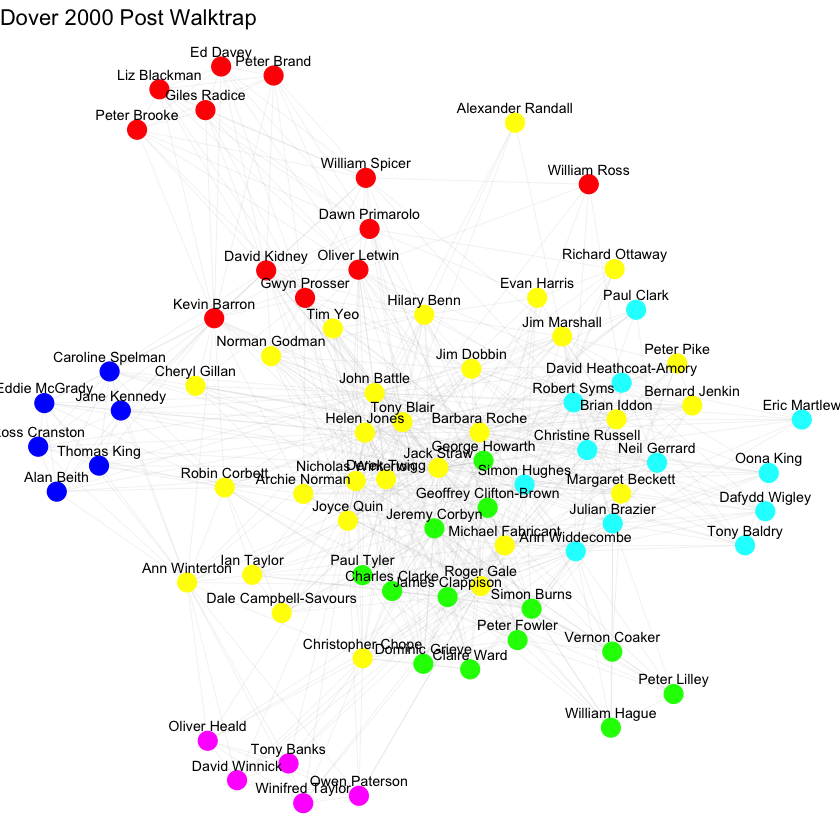

In [138]:
layout <- layout_with_fr(gD2_post)

ggraph(gD2_post, layout = 'fr') +  # Use the Fruchterman-Reingold layout
  geom_edge_link(alpha = 0.5, color = "grey", width = 0.1) +  # Edges with width and transparency
  geom_node_point(aes(color = factor(membership(c_sub_post))), size = 5) +  # Nodes colored by community
  geom_node_text(aes(label = name), size = 3, vjust = -1) +  # Node labels with adjusted size
  ggtitle("Dover 2000 Post Walktrap") +  # Title from your original code
  scale_color_manual(values = rainbow(length(unique(membership(c_sub_post))))) +  # Community colors
  theme_void() +  # Clean background (no axes)
  theme(legend.position = "none") 

### Combine subset with centrality

[1] 0.7973734 0.3753261 2.6429305 1.1504574 1.0199396 6.1815406 1.4290039
 [8] 2.3569813 1.0684507 2.2666742 0.9318720 3.2163648 0.7525691 1.1976806
[15] 1.0961251 1.1336353 2.2090377 0.5744225 0.9575726 2.0496182 1.1976806
[22] 0.2892563 0.7973734 0.8434248 0.8892516 1.8408084 0.2892563 2.0165030
[29] 3.9009531 1.4235101 1.1336353 8.0000000 2.9174816 1.0684507 3.0090724
[36] 2.2745274 1.7543002 4.6549011 0.7057583 1.9264179 3.1008367 1.9095854
[43] 0.2892563 1.9041712 3.8735304 1.4576583 1.9161658 2.0496182 0.9103893
[50] 2.5727027 1.0961251 0.8746866 2.2666742 0.2892563 0.2892563 1.8961740
[57] 0.7525691 1.4290039 0.6956246 3.4673856 1.8774665 2.5647588 0.7973734
[64] 1.6792619 3.1825712 1.9376464 0.9103893 0.3015477 1.0961251 4.9528338
[71] 0.5294711 0.7525691 0.6657542

Warning message in layout[, 1] + label.dist * cos(-label.degree) * (vertex.size + :
“longer object length is not a multiple of shorter object length”Warning message in layout[, 2] + label.dist * sin(-label.degree) * (vertex.size + :
“longer object length is not a multiple of shorter object length”Warning message in layout[, 1] + label.dist * cos(-label.degree) * (vertex.size + :
“longer object length is not a multiple of shorter object length”Warning message in layout[, 2] + label.dist * sin(-label.degree) * (vertex.size + :
“longer object length is not a multiple of shorter object length”

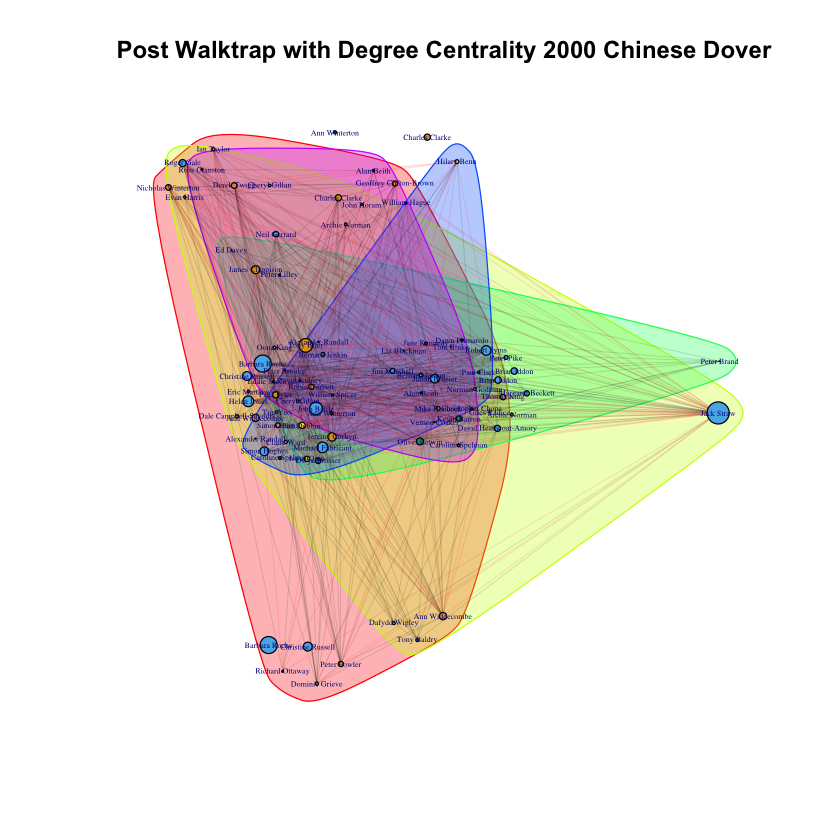

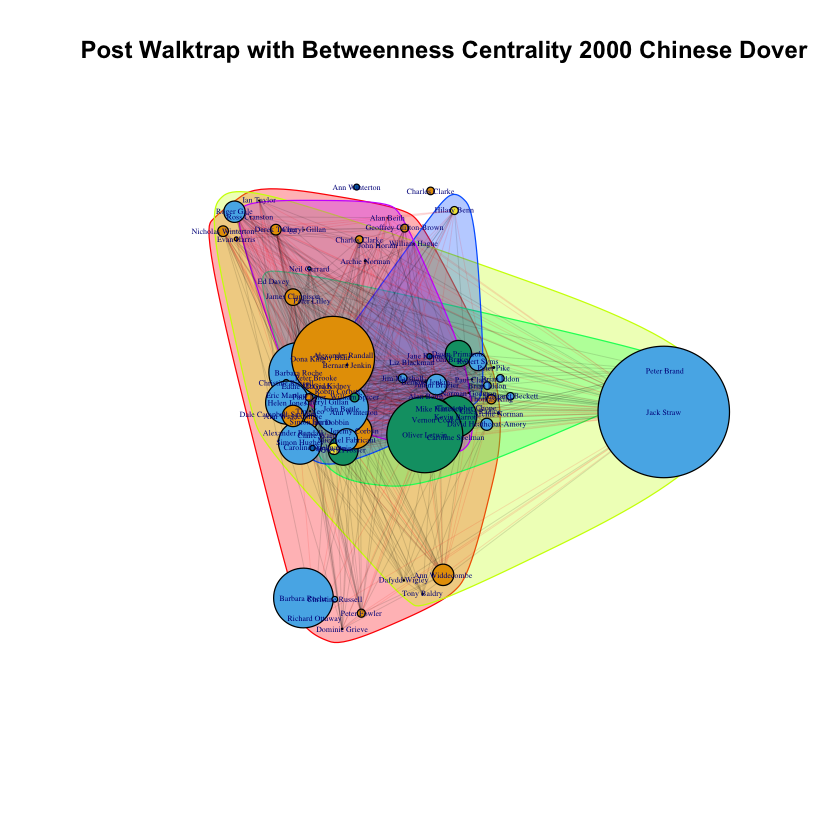

In [93]:
##NEW CODE TO VISUALIZE COMMUNITIES BASED ON NODE CENTRALITY

## Eigenvector centrality 
label21 = paste("Post Walktrap with Degree Centrality", event_name, sep=" ")
label22 = paste("Post Walktrap with Betweenness Centrality", event_name, sep=" ")

eigen_post <-  eigen_centrality(gD2) # use actor-actor network 
#eigen_post$vector

V(gD2)$eigen <- (eigen_post$vector*8) #size the network nodes by their node degree and attach to network graph 

V(gD2)$eigen

# show communities including nodes sized by eigen centrality  (use same layout as before)
set.seed(1)
plot(cluster_post2,gD2, layout = l2*2, vertex.size = V(gD2)$eigen, edge.width = .1,
     vertex.label.cex=.4, main = label21)

## Betweeness Centrality 
# attach to vertexes 
V(gD2)$between <- betweenness(gD2, normalized = T)

set.seed(1)
plot(cluster_post2,gD2, layout = l2*8, vertex.size = V(gD2)$between*500, edge.width = .1,
     vertex.label.cex=.4, main = label22)

## Extract Info on Speakers and Membership

In [94]:
### how to figure out who is in what community based on topics 
cluster_post <- cluster_walktrap(bn.mem_f_post, steps=2)
walk_comm <- as.data.frame(as.table(membership(cluster_post)))
names(walk_comm) <- c("Speaker", "Community")

# create pre dataset again with speakers etc 
dfg_post_2 <- subset(dfg, date>= event & date <= after_90) %>%
    select(-date)


dfg_post_2 = aggregate(dfg_post_2,
                      by = list(dfg_post_2$author),
                      FUN = max)

dfg_post_2 <- dfg_post_2 %>%
  select(-Group.1)

In [95]:
# Extract just names of speakers in each community 
fname = paste(event_name_post, "SpeakerbyCommunity.csv", sep="_")

post_2steps_comm <- walk_comm
write.csv(post_2steps_comm, file=fname)

In [96]:
fname2 = paste(event_name_post, "SpeakerbyTopic.csv", sep="_")

head(dfg_post_2, 3)
write.csv(dfg_post_2, file=fname2)

author            V1 V2 V3 V4 V5 V6 V7 V8 V9 ... V11 V12 V13 V14 V15 V16 V17
1 Alan Beith        0  0  0  0  0  1  0  0  0  ... 0   0   0   0   0   0   0  
2 Alexander Randall 0  0  0  0  0  0  0  0  0  ... 1   0   0   0   0   0   0  
3 Andrew Rowe       0  0  0  0  0  0  0  0  0  ... 0   0   0   0   0   0   0  
  V18 V19 V20
1 0   0   0  
2 0   0   0  
3 1   0   0

In [97]:
# merge the dataset with communities now 
merge_dfg_post <- merge(walk_comm, dfg_post_2, walk_comm,  by.y = "author", by.x = "Speaker")

merge_dfg_post[-1] <- lapply(merge_dfg_post[-1], as.numeric)

# now create different metrics to see topic distribution per speaker/community
merge_dfg_post <- merge_dfg_post %>%
  mutate(topic_sum = rowSums(.[3:22])) %>%
  group_by(Community) %>%
  mutate(topic_mean = mean(topic_sum), topic_median = median(topic_sum), 
         topic_min = min(topic_sum),topic_max = max(topic_sum))

In [98]:
### Communities and Topics 

p1<- ggplot(merge_dfg_post, aes(Community, topic_mean)) +
  geom_bar(aes(fill=topic_mean),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "maroon") +
  theme_bw() +
  ylab("Average Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, size=.5)) +
  ggtitle("Average Number of Topics per Community\n")

In [99]:
p2 <-  ggplot(merge_dfg_post, aes(Community, topic_median)) +
  geom_bar(aes(fill=topic_median),
           stat = "identity",
           position = "dodge") +
  #scale_x_continuous(breaks = c(1, 12, 1))+
  #scale_x_discrete(limits=1:12)+
  scale_x_continuous(breaks = c(0:12)) +
  scale_fill_gradient(low = "grey", high = "darkseagreen4") +
  theme_bw() +
  ylab("Median Number of Topics\n") + xlab("Community\n") +
  theme(plot.title = element_text(hjust = 0.5, size=15),
        strip.text = element_text(size = 16.5),
        axis.text.y = element_text(size = 10),
        axis.text.x = element_text(size = 10),
        axis.title.x = element_text(size = 12), 
        axis.title.y = element_text(size = 12), 
        legend.position = "none", 
        #legend.direction = "horizontal",
        #legend.justification=c(.5, .5),
        #legend.background = element_rect(colour="gray60"),
        #legend.title.align = 0.5,
        #legend.text = element_text(size=8),
        #legend.title = element_blank("Average # Topics"),
        panel.border = element_rect(colour = "black", fill=NA, size=.5)) +
  ggtitle("Median Number of Topics per Community\n")

In [100]:
#grid.arrange(p1, p2, nrow = 1) 
fname3 = paste(event_name_post, "NumSpeakersperCommunity.csv", sep="_")

# overall how often each topic is talked about 
colSums(merge_dfg_post[ , c(3:22)], na.rm=TRUE)

# now how often each topic is talked about per community (ignore other columns, just focus on V1:V20)
aggregate(.~Community, merge_dfg_post, sum)
walktrap_2steps_post <- aggregate(.~Community, merge_dfg_post, sum)
write.csv(walktrap_2steps_post, file=fname3)

# count how many people in each community 
merge_dfg_post %>% count(Community)

V1  V2  V3  V4  V5  V6  V7  V8  V9 V10 V11 V12 V13 V14 V15 V16 V17 V18 V19 V20 
  8   4   8   8   7  12  12  10  12  11   5  12  15   3   7   8   7   7   9  16

Community Speaker V1 V2 V3 V4 V5 V6 V7 V8 ... V16 V17 V18 V19 V20 topic_sum
1 1         1094    1  2  7  3  2  3  12 3  ... 7   6   1   3    1  75       
2 2         1253    2  0  1  4  1  2   0 7  ... 1   1   3   4   14  62       
3 3          492    0  0  0  1  2  1   0 0  ... 0   0   0   2    1  21       
4 4          230    0  0  0  0  0  6   0 0  ... 0   0   0   0    0  11       
5 5           86    0  2  0  0  0  0   0 0  ... 0   0   0   0    0   2       
6 6          300    5  0  0  0  0  0   0 0  ... 0   0   0   0    0   5       
7 7           87    0  0  0  0  0  0   0 0  ... 0   0   3   0    0   3       
8 8          113    0  0  0  0  2  0   0 0  ... 0   0   0   0    0   2       
  topic_mean topic_median topic_min topic_max
1 75         50           25        275      
2 62         60           30        240      
3 21         22           11         44      
4 11          7            7         21      
5  2          2            2          2      
6  5          5            5          5      
7  3          3            3          3      
8  2          2            2          2

Community n 
1 1         25
2 2         30
3 3         11
4 4          7
5 5          2
6 6          5
7 7          3
8 8          2

## <font color='Red'> 7.1 SUBGraph Measures of Centrality, Transitivity, etc.</font>

In [91]:
pre_cent = centr_degree(gD2_pre)$centralization  ### somewhat high: 0.56 --> this speaks confirms that the network
pre_centrality = paste("Centrality of Pre", event_name, ":", pre_cent, sep=" ")
print(pre_centrality)
# is rather decentralized and hierarchical, with only a few nodes/actors being most important 
post_cent = centr_degree(gD2_post)$centralization
post_centrality = paste("Centrality of Post", event_name, ":", post_cent, sep=" ")
print(post_centrality)

[1] "Centrality of Pre 2000 Chinese Dover : 0.461054287962234"
[1] "Centrality of Post 2000 Chinese Dover : 0.553113553113553"


In [92]:
pre_edge = edge_density(gD2_pre) 
pre_edge_density = paste("Edge Density of Pre", event_name, ":", pre_edge, sep=" ")
print(pre_edge_density)


post_edge = edge_density(gD2_post)
post_edge_density = paste("Edge Density of Post", event_name, ":", post_edge, sep=" ")
print(post_edge_density)


[1] "Edge Density of Pre 2000 Chinese Dover : 0.262522947810123"
[1] "Edge Density of Post 2000 Chinese Dover : 0.226107226107226"


In [93]:
pre_trans = transitivity(gD2_pre) 
pre_transitivity = paste("Transitivity of Pre", event_name, ":", pre_trans, sep=" ")
print(pre_transitivity)

post_trans = transitivity(gD2_post)
post_transitivity = paste("Transitivity of Post", event_name, ":", post_trans, sep=" ")
print(post_transitivity)

### 0.60 --> pretty high 

[1] "Transitivity of Pre 2000 Chinese Dover : 0.627991872031756"
[1] "Transitivity of Post 2000 Chinese Dover : 0.538456516061635"


In [94]:
pre_dis = mean_distance(gD2_pre) 
pre_mean_distance = paste("Mean Distance of Pre", event_name, ":", pre_dis, sep=" ")
print(pre_mean_distance)

post_dis = mean_distance(gD2_post)
post_mean_distance = paste("Mean Distance of Post", event_name, ":", post_dis, sep=" ")
print(post_mean_distance)

### 1.7 --> nodes are on average 1.7 steps away from one another 

[1] "Mean Distance of Pre 2000 Chinese Dover : 1.811303435615"
[1] "Mean Distance of Post 2000 Chinese Dover : 1.86546786546787"


In [105]:
pre_med = median(degree(bn.mem_f_pre)) 
pre_median = paste("Median Connections of Pre", event_name, ":", pre_med, sep=" ")
print(pre_median)

post_med = median(degree(bn.mem_f_post)) 
post_median = paste("Median Connections of Post", event_name, ":", post_med, sep=" ")
print(post_median)

### median is 44 --> actors on average have 34 connections 

[1] "Median Connections of Pre 2000 Chinese Dover : 32"
[1] "Median Connections of Post 2000 Chinese Dover : 15"


In [106]:
pre_mean = mean(degree(bn.mem_f_pre)) 
pre_mean_d = paste("Mean Connections of Pre", event_name, ":", pre_mean, sep=" ")
print(pre_mean_d)

post_mean = mean(degree(bn.mem_f_post)) 
post_mean_d = paste("Mean Connections of Post", event_name, ":", post_mean, sep=" ")
print(post_mean_d)

### mean is 44 --> actors on average have 44 connections 

[1] "Mean Connections of Pre 2000 Chinese Dover : 31.8888888888889"
[1] "Mean Connections of Post 2000 Chinese Dover : 16.7058823529412"
